# Qdrant 101

![qdrant](https://qdrant.tech/images/logo_with_text.png)

Vector databases are a relatively new way for interacting with abstract data representations derived from opaque machine learning models -- deep learning architectures being the most common ones. These representations are often called vectors or embeddings and they are a compressed version of the data used to train a machine learning model to accomplish a task (e.g., sentiment analysis, speech recognition, object detection, and many more).

Vector databases shine in many applications like semantic search and recommendation systems, and in this tutorial, we'll learn about how to get started with one of the most popular and fastest growing vector databases in the market, Qdrant.

## Table of Contents

1. Learning Outcomes
2. What is Qdrant?
    - What are Vector Databases?
    - Why do We Need Vector Databases??
    - Overview of Qdrant's Architecture    
    - How do We Get Started?
3. Getting Started
    - Adding Points
    - Payload
    - Search
4. NLP & Vector Databases
5. Conclusion
6. Resources

## 1. Learning Outcomes

By the end of this tutorial, you will be able
- Describe what are vector databases and what are they used for.
- Extract vectors from text text data.
- Create, update, and query collections of vectors using Qdrant.
- Fine-tune a model on your own dataset and create better vectors.
- Visualize your collections of data.

## 2. What is Qdrant?

Qdrant "is a vector similarity search engine that provides a production-ready service with a convenient API to store, search, and manage points (i.e. vectors) with an additional payload." You can get started with plain python using the `qdrant-client`, pull the latest docker image of `qdrant` and connect to it locally, or try out Qdrant's Cloud free tier option until you are ready to make the full switch.

### 2.1 What Are Vector Databases?

A vector database is a type of database designed to store and query high-dimensional vectors efficiently. In traditional [OLTP](https://www.ibm.com/topics/oltp) and [OLAP](https://www.ibm.com/topics/olap) databases, data is organized in rows and columns, and queries are performed based on the values in those columns. However, in certain applications including image recognition, natural language processing, and recommendation systems, data is often represented as vectors in a high-dimensional space. Here is a depiction of all three next to each other.

![dbs](../images/databases.png)

A vector in this context is a mathematical representation of an object or data point, where each element of the vector corresponds to a specific feature or attribute of the object. For example, in an image recognition system, a vector could represent an image, with each element of the vector representing a pixel value or a descriptor/characteristic of that pixel.

Vector databases are optimized for **storing** and **querying** these high-dimensional vectors efficiently, often using specialized data structures and indexing techniques such as Hierarchical Navigable Small World (HNSW), Approximate Nearest Neighbors, and Product Quantization, among others. These databases enable fast similarity and semantic search while allowing users to find vectors that are the closest to a given query vector based on some distance metric. The most commonly used distance metrics are Euclidean Distance, Cosine Similarity, and Dot Product.

### 2.2 Why do we need Vector Databases?

Vector databases play a crucial role in various applications that require similarity search, such as recommendation systems, content-based image retrieval, and personalized search. By taking advantage of their efficient indexing and searching techniques, vector databases enable faster and more accurate retrieval of similar vectors, which helps advance data analysis and decision-making.

In addition, other benefits of using vector databases include:
1. Efficient storage and indexing of high-dimensional data.
3. Ability to handle large-scale datasets with billions or trillions of data points.
4. Support for real-time analytics and queries.
5. Ability to handle complex data types, such as images, videos, and natural language text.
6. Improved performance and reduced latency in machine learning and AI applications.
7. Reduced development and deployment time and cost compared to building a custom solution.

Keep in mind that the specific benefits of using a vector database may vary depending on the use case of your organization and the features of the database.

### 2.3 Overview of Qdrant's Architecture (High-Level)

![qdrant](../images/qdrant_overview_high_level.png)

The diagram above represents a high-level overview of some of the main components of Qdrant. Here are the terminologies you should get familiar with.

- [Collections](https://qdrant.tech/documentation/collections/): A collection is a named set of points (vectors with a payload) among which you can search. Vectors within the same collection must have the same dimensionality and be compared by a single metric.
- Distance Metrics: These are used to measure similarities among vectors and they must be selected at the same time you are creating a collection. The choice of metric depends on the way vectors obtaining and, in particular, on the method of neural network encoder training.
- [Points](https://qdrant.tech/documentation/points/): The points are the central entity that Qdrant operates with and they consist of a vector and an optional id and payload.
- id: a unique identifier for your vectors.
- Vector: a high-dimensional representation of data, for example, an image, a sound, a document, a video, etc.
- [Payload](https://qdrant.tech/documentation/payload/): A payload additional data you can add to a vector.
- [Storage](https://qdrant.tech/documentation/storage/): Qdrant can use one of  two options for storage, **In-memory** storage (Stores all vectors in RAM, has the highest speed since disk access is required only for persistence), or **Memmap** storage, (creates a virtual address space associated with the file on disk).
- Clients: the programming languages you can use to connect to Qdrant.

### 2.4 How do we get started?

The open source version of Qdrant is available as a docker image and it can be pulled and run from any machine with docker installed. If you don't have Docker installed in your PC you can follow the instructions in the official documentation [here](https://docs.docker.com/get-docker/). After that, open your terminal start by downloading the image with the following command.

```sh
docker pull qdrant/qdrant
```

Next, initialize Qdrant with the following command, and you should be good to go.

```sh
docker run -p 6333:6333 \
    -v $(pwd)/qdrant_storage:/qdrant/storage \
    qdrant/qdrant
```

You should see something similar to the following image.

![dockerqdrant](../images/docker_qdrant.png)

If you experience any issues during the start process, please let us know in our [discord channel here](https://qdrant.to/discord). We are always available and happy to help.

Now that you have Qdrant up and running, your next step is to pick a client to connect to it. We'll be using Python as it has the most mature data tools' ecosystem out there. Therefore, let's start setting up our dev environment and getting the libraries we'll be using today.

```sh
# with mamba or conda
mamba env create -n my_env python=3.10
mamba activate my_env

# or with virtualenv
python -m venv venv
source venv/bin/activate

# install packages
pip install qdrant-client transformers datasets pandas numpy torch
```

After your have your environment ready, let's get started with Qdrant.

**Note:** At the time of writing, Qdrant supports Rust, GO, Python and TypeScript. We expect other programming languages to be added in the future.

## 3. Getting Started

The two modules we'll use the most are the `QdrantClient` and the `models` one. The former allows us to connect to Qdrant or it allows us to run an in-memory database by switching the parameter `host=` to `":memory:"` (this is a great feature for testing in a CI/CD pipeline). We'll start by instantiating our client using `host="localhost"` and `port=6333` (as it is the default we used earlier with docker).

In [49]:
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import CollectionStatus

In [50]:
client = QdrantClient(host="localhost", port=6333)
client

In OLTP and OLAP databases we call specific bundles of rows and columns **Tables**, but in vector databases the rows are known as vectors, the columns are known as dimensions, and the combination of the two (plus some metadata) as **collections**.

In the same way in which we can create many tables in a database, we can create many collections in a vector-based database using a client. The key difference to note is that when we create a collection, we need to specify the width of the collection (i.e. the length of the vector or amount of dimensions) beforehand with the parameter `size=...`, as well as the similarity metric with the parameter `distance=...` (which can be changed later on).

The distances currently supported by Qdrant are:
- [**Cosine Similarity**](https://en.wikipedia.org/wiki/Cosine_similarity) - Cosine similarity is a way to measure how similar two things are. Think of it like a ruler that tells you how far apart two points are, but instead of measuring distance, it measures how similar two things are. It's often used with text to compare how similar two documents or sentences are to each other. The output of the cosine similarity ranges from 0 to 1, where 0 means the two things are completely dissimilar, and 1 means the two things are exactly the same. It's a straightforward and effective way to compare two things!
- [**Dot Product**](https://en.wikipedia.org/wiki/Dot_product) - The dot product similarity metric is another way of measuring how similar two things are, like cosine similarity. It's often used in machine learning and data science when working with numbers. The dot product similarity is calculated by multiplying the values in two sets of numbers, and then adding up those products. The higher the sum, the more similar the two sets of numbers are. So, it's like a scale that tells you how closely two sets of numbers match each other.
- [**Euclidean Distance**](https://en.wikipedia.org/wiki/Euclidean_distance) - Euclidean distance is a way to measure the distance between two points in space, similar to how we measure the distance between two places on a map. It's calculated by finding the square root of the sum of the squared differences between the two points' coordinates. This distance metric is commonly used in machine learning to measure how similar or dissimilar two data points are or, in other words, to understand how far apart they are.

Let's create our first collection and have the vectors be of with 100 and the distance set to **Cosine Similarity**. Please note that, at the time of writing, Qdrant supports cosine similarity, dot product and euclidean distance.

In [ ]:
my_collection = "first_collection"

first_collection = client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=100, distance=models.Distance.COSINE)
)
print(first_collection)

We can extract information related to the health of our collection by getting the collection. In addition, we can use this information for testing purposes, which can be very beneficial while in development mode.

In [ ]:
collection_info = client.get_collection(collection_name=my_collection)
collection_info

In [ ]:
assert collection_info.status == CollectionStatus.GREEN
assert collection_info.vectors_count == 0

There's a couple of things to notice from what we have done so far.
- The first is that when we initiated our docker image, we created a local directory called, `qdrant_storage`, and this is where all of our collections, plus their metadata, will be saved at. You can have a look at that directory in a *nix system with `tree qdrant_storage -L 2`, and something similar to the following should come up for you.
    ```bash
    qdrant_storage
    ├── aliases
    │   └── data.json
    ├── collections
    │   └── my_first_collection
    └── raft_state
    ```
- The second is that we used `client.recreate_collection` and this command, as the name implies, can be used more than once for a collection with the same name, so be careful no to recreate a collection that you did not intend to recreate. To create a brand new collection where trying to recreate another of the same name would throw an error, we would use `client.create_collection` instead.
- Our collection can only hold vectors of 100 dimensions and the distance metric has been set to Cosine Similarity.

Now that we know how to create collections, let's create a bit of fake data and add some vectors to our collection.

### 3.1 Adding Points

The points are the central entity that Qdrant operates with, and these points contain records consisting of a vector, an optional id and an optional payload (which we'll talk more about in the next section).

The optional id can be represented by unassigned integers or UUIDs but, for our use case, we will use a straightforward range of numbers.

Let's create a matrix of fake data containing 1,000 rows and 100 columns while representing the values of our vectors as `float64` numbers between -1 and 1. For simplicity, let's imagine that each of these vectors represents one of our favorite songs, and that each columns represents a unique characteristic of the artists/bands we love, for example, the tempo, the beats, the pitch of the voice of the singer(s), etc.

In [ ]:
import numpy as np

In [ ]:
data = np.random.uniform(low=-1.0, high=1.0, size=(1_000, 100))
type(data[0, 0]), data[:2, :20]

Let's know create an index for our vectors.

In [ ]:
index = list(range(len(data)))
index[-10:]

Once the collection has been created, we can fill it in with the command `client.upsert()`. We need the collection's name and the appropriate process from our `models` module, in this case, [`Batch`](https://qdrant.tech/documentation/points/#upload-points).

One thing to note is that Qdrant can only take in native Python iterables like lists and tuples. This is why you'll notice the `.tolist()` method attached to our `data` below.

In [ ]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=index,
        vectors=data.tolist()
    )
)

We can retrieve specific points based on their ID (for example, artist X with ID 1000) and get some additional information from that result.

In [ ]:
client.retrieve(
    collection_name=my_collection,
    ids=[100],
    with_vectors=True # we can turn this on and off depending on our needs
)

We can also update our collection one point at a time, for example, as new data comes in.

In [ ]:
def create_song():
    return np.random.uniform(low=-1.0, high=1.0, size=100).tolist()

In [ ]:
client.upsert(
    collection_name=my_collection,
    points=[
        models.PointStruct(
            id=1000,
            vector=create_song(),
        )
    ]
)

We can also delete it in a straightforward fashion.

In [ ]:
client.count(
    collection_name=my_collection, 
    exact=True,
)

In [ ]:
client.delete(
    collection_name=my_collection,
    points_selector=models.PointIdsList(
        points=[1000],
    ),
)

In [ ]:
client.count(
    collection_name=my_collection, 
    exact=True,
)

### 3.2 Payloads

Qdrant has incredible features on top of speed and reliability, and one of its most useful ones is without a doubt the ability to store additional information along with vectors. In Qdrant terminology, this information is considered a payload and it is represented as JSON objects. In addition, not only can you get this information back when you search in the database, but you can also filter your search by the parameters in the payload, and we'll see how in a second.

Imagine the fake vectors we created actually represented a song. If we were building a recommender system for songs then, naturally, the things we would want to get back would be the song itself, the artist, maybe the genre, and so on.

What we'll do here is to take advantage of a Python package call `faker` and create a bit of information to add to our payload and see how this functionality works.

In [ ]:
from faker import Faker

In [ ]:
fake_something = Faker()
fake_something.name()

In [ ]:
payload = []

for i in range(len(data)):
    payload.append(
        {
            "artist":   fake_something.name(),
            "song":     " ".join(fake_something.words()),
            "url_song": fake_something.url(),
            "year":     fake_something.year(),
            "country":  fake_something.country()
        }
    )

payload[:3]

In [ ]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=index,
        vectors=data.tolist(),
        payloads=payload
    )
)

In [ ]:
resutls = client.retrieve(
    collection_name=my_collection,
    ids=[10, 50, 100, 500],
    with_vectors=False
)
resutls

In [ ]:
resutls[0].payload

### 3.3 Search

Now that we have our vectors with an ID and a payload, we can explore a few of ways in which we can search for content when, in our use case, new music gets selected. Let's check it out.

Say, for example, that a new song comes in and our model immediately transforms it into a vector.

In [ ]:
living_la_vida_loca = create_song()

In [ ]:
client.search(
    collection_name=my_collection,
    query_vector=living_la_vida_loca,
    limit=10
)

Now imagine that we only want Australian songs recommended to us.

In [ ]:
aussie_songs = models.Filter(
    must=[models.FieldCondition(key="country", match=models.MatchValue(value="Australia"))]
)

In [ ]:
client.search(
    collection_name=my_collection,
    query_vector=living_la_vida_loca,
    query_filter=aussie_songs,
    limit=5
)

Lastly, say we want aussie songs but we don't care how new or old these songs are.

In [ ]:
client.search(
    collection_name=my_collection,
    query_vector=living_la_vida_loca,
    query_filter=aussie_songs,
    with_payload=models.PayloadSelectorExclude(exclude=["year"]),
    limit=5
)

As you can see, you can apply a wide-range of filtering methods to allows your users to take more control of the recommendations they are being served.

If you wanted to clear out the payload and upload a new for the same vectors, you can use `client.clear_payload()` as in the cell below.

In [ ]:
client.clear_payload(
    collection_name="my_first_collection",
    points_selector=models.PointIdsList(
        points=index,
    )
)

## 4. NLP & Vector Databases

The most common use case you will find at the time of writing, will likely involve language-based models. You might have heard of models like [GPT-4](https://openai.com/product/gpt-4), [Codex](https://openai.com/blog/openai-codex), and [PaLM-2](https://ai.google/discover/palm2) which are powering incredible tools such as [ChatGPT](https://openai.com/blog/chatgpt), [GitHub Copilot](https://github.com/features/copilot), and [Bard](https://bard.google.com/?hl=en), respectively. These three models are part of a family of deep learning architectures called [transformers](https://arxiv.org/abs/1706.03762). Which are known for their ability to learn long-range dependencies between words in a sentence, and that makes them well-suited for tasks such as machine translation, text summarization, and question answering.

Transformer models work by using a technique called attention, which allows them to focus on different parts of a sentence when making predictions. For example, if you are trying to translate a sentence from English to Spanish, the transformer model will use attention to focus on the words in the English sentence that are most important for the translation into Spanish.

One analogy that can be used to explain transformer models is to think of them as a group of people who are trying to solve a puzzle. Each person in the group is given a different piece of the puzzle, and they need to work together to figure out how the pieces fit together. The transformer model is like the group of people, and the attention mechanism is like the way that the people in the group communicate with each other.

In a more concise way, transformer models are a type of machine learning model that can learn long-range dependencies between words in a sentence by using (or paying 😉) attention.

In NLP, vector databases are used to store word embeddings. Word embeddings are vector representations of words that capture their semantic meaning. They are used to improve the performance of NLP tasks such as text classification, machine translation, and question answering.

The best part about transformers the models, and `transformers` the Python library, is that we can get these embeddings in very straightforward way.

Before we get started with the model, let's talk about the use case we will be covering here.

> We have been given the **task of creating a system** that, **given a news article** chosen by a user, it will **give recommends 10 other articles based on the most similar context** to the article chosen.

The dataset we will use can is called the **AG News** dataset and here is a description from its [dataset card in Hugging Face](https://huggingface.co/datasets/ag_news):

> "AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity. For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html"

In [34]:
from datasets import load_dataset

In [35]:
dataset = load_dataset("ag_news", split="train")
dataset

Found cached dataset ag_news (/home/ramonperez/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

If you have never used HuggingFace's [`datasets`](https://huggingface.co/docs/datasets/index) library you might be a little puzzled regarding what just happened. Let's break it apart.

- The `datasets` library is a tool that allows us to manipulate unstructured data in a very efficient way by using [Apache Arrow](https://arrow.apache.org/) under the hood. It has a lot of useful functionalities for massaging and shaping up the data in whatever way we need it to be for our task. (It is safe to call it the pandas of unstructured data.)
- Next, we imported the `load_dataset` function and used it to download the dataset from the [HuggingFace Data Hub](https://huggingface.co/datasets) directly into our PC's.
- Lastly, by indicating that we want to "split" our dataset into a `train` set only, we are effectively indicating that we do not want any partitions.

Let's have a look at a couple of samples.

In [36]:
from random import choice

for i in range(5):
    random_sample = choice(range(len(dataset)))
    print(f"Sample {i+1}")
    print("=" * 70)
    print(dataset[random_sample]['text'])
    print()

Sample 1
Bilonog Edges Nelson With Last Put as Shot Returns to Olympia Aug. 18 (Bloomberg) -- Yuriy Bilonog won the gold medal in the men #39;s shot put at Olympia, the home of the ancient Games, by virtue of his second-best effort after his last throw matched the leading mark set by US athlete Adam Nelson. 

Sample 2
Gold Fields appeal  #39;a delaying tactic #39; The objection to aspects of Harmony #39;s bid for Gold Fields, submitted by Gold Fields to the Securities Regulation Panel (SRP), is purely a delaying tactic, Harmony CEO Bernard Swanepoel told I-Net Bridge on Friday.

Sample 3
Howard defiant as attacks mount PRIME Minister John Howard conceded yesterday a fresh inquiry into the children overboard saga would find he had lied. 

Sample 4
Unemployment down by 16,000 The number of people claiming unemployment benefit last month fell by 6,100 to 830,200, the Office for National Statistics said. Average earnings, including bonuses, increased by 3.8 in the year to July, down 

Samp

One nice feature of HuggingFace datasets' objects is that we can switch effortlessly to pandas dataframe by using the method `.pandas()`. This allows us to take advantage of may of the nice tools pandas comes with for manipulating the data and plotting it. Let's have a look at the distribution of the labels, but before we do that, let's extract the class names of our dataset as we will be needing it shortly. 

In [37]:
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

num_labels = len(id2label)

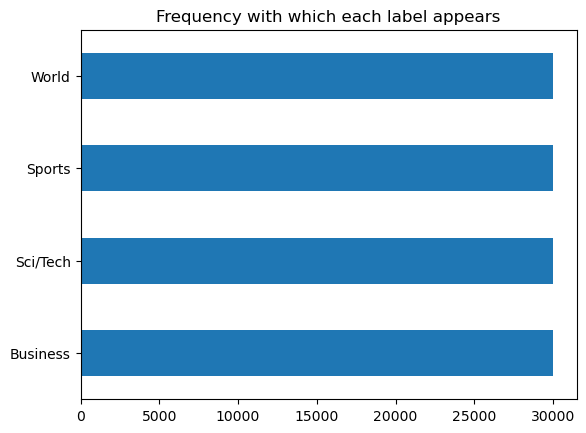

In [38]:
(
    dataset.select_columns('label')
           .to_pandas()
           .astype(str)['label']
           .map(id2label)
           .value_counts()
           .plot(kind="barh", title="Frequency with which each label appears")
);

As you can see, we have an very well-balanced dataset at our disposal. Let's look at the average length of news per class label.

In [39]:
def get_lenght_of_text(example):
    example['length_of_text'] = len(example['text'])
    return example

dataset = dataset.map(get_lenght_of_text)
dataset[:10]['length_of_text']

Loading cached processed dataset at /home/ramonperez/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-e971d9966c1fdaf5.arrow


[144, 266, 232, 256, 234, 239, 215, 252, 414, 147]

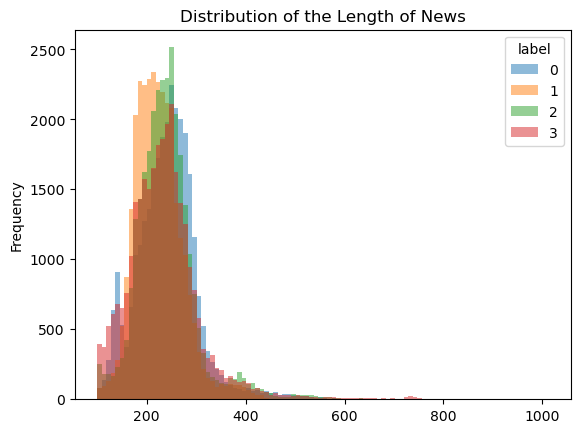

In [40]:
(
    dataset.select_columns(["label", "length_of_text"])
           .to_pandas()
           .pivot(columns='label', values='length_of_text')
           .plot.hist(
                bins=100, alpha=0.5, #log=True,
                title="Distribution of the Length of News"
           )
);

The length of the news for all the labels seems to be quite similar and with a few outliers here and there.

Our next step will be to get a trained model and use it to tokenize our data and create an embedding layer based on it.

Tokenization is like breaking down a sentence into smaller pieces called "tokens." It's similar to how we break a sentence into words, but tokens can be words, numbers, curly brackets, or even punctuation marks. This process helps computers understand and analyze text more easily because they can treat each token as a separate unit and work with them individually. It's like taking a sentence and turning it into a set of building blocks that a computer can understand and manipulate.

The model we will use to extract the tokenize our news and extract the embeddings is GPT-2. GPT-2 is a powerful language model created by OpenAI, and it is like a super-smart computer program that has been trained on a lot of text from the internet. You can think of it as an AI that can generate human-like text and answer questions based on what it has learned. GPT-2 can be used for a variety of things, like writing articles, creating chatbots, generating story ideas, or even helping with language translation. It's a tool that helps computers understand and generate text in a way that seems very human-like.

The process is similar to that with the `datasets` library, we will use two classes from the `transformers` library, GPT2Tokenizer and GPT2Model, and these will make use of the model checkpoint of GPT-2 that we pass to it. The example below takes inspiration from an example available on Chapter 9 of the excellent book, [Natural Language Processing with Transformers](https://transformersbook.com/) by Lewis Tunstall, Leandro von Werra, and Thomas Wolf.

In [6]:
from transformers import GPT2Tokenizer, GPT2Model
import numpy as np
import torch

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')#.to(device)

In natural language processing (NLP), padding refers to adding extra tokens to make all input sequences the same length. When processing text data, it's common for sentences or documents to have different lengths. However, many machine learning models require fixed-size inputs. Padding solves this issue by adding special tokens (such as zeros) to the shorter sequences, making them equal in length to the longest sequence in the dataset.

For example, let's say you have a set of sentences: "I love cats," "Dogs are friendly," and "Birds can fly." If you want to process them using a model that requires fixed-length input, you may pad the sequences to match the length of the longest sentence, let's say five tokens. The padded sentences would look like this:

1. "I love cats" -> "I love cats [PAD] [PAD]"
2. "Dogs are friendly" -> "Dogs are friendly [PAD]"
3. "Birds can fly" -> "Birds can fly [PAD] [PAD]"

By padding the sequences, you ensure that all inputs have the same size, allowing the model to process them uniformly. Padding is a common preprocessing step in NLP tasks like text classification, sentiment analysis, and machine translation.

Because GPT-2 does not have a padding token, we will use the "end of text" token instead.

In [9]:
tokenizer.eos_token

'<|endoftext|>'

In [10]:
tokenizer.pad_token

Using pad_token, but it is not set yet.


In [11]:
tokenizer.pad_token = tokenizer.eos_token

 With that out of the way, let's walk through a quick example.

In [22]:
text = "What does a cow use to do math? A cow-culator."
inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")#.to(device)
inputs

{'input_ids': tensor([[ 2061,   857,   257,  9875,   779,   284,   466, 10688,    30,   317,
          9875,    12,  3129,  1352,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [5]:
tokenizer.c

Object `tokenizer` not found.


In [23]:
toks = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
toks

['What',
 'Ġdoes',
 'Ġa',
 'Ġcow',
 'Ġuse',
 'Ġto',
 'Ġdo',
 'Ġmath',
 '?',
 'ĠA',
 'Ġcow',
 '-',
 'cul',
 'ator',
 '.']

In [17]:
tokenizer.convert_tokens_to_string(toks)

'What does a cow use to do math? A cow-culator.'

In [18]:
tokenizer.vocab_size

50257

In [19]:
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

In [20]:
tokenizer.model_max_length

1024

In [21]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Now it is time to pass the inputs we got from our tokenizer to our model and examine what we'll get in return.

In [ ]:
with torch.no_grad():
    embs = model(**inputs)

embs.last_hidden_state.size(), embs

Notice that we got a tensor of shape `[batch_size, inputs, dimensions]`. The inputs are our tokens and these dimensions are the embedding representation that we want for our sentence rather than each token. So what can we do to get one rather than 15? The answer is **mean pooling**. We are going to take the average of all 15 vectors while paying attention to the most important parts of it. The details of how this is happening are outside of the scope of this tutorial, but please refer to the Natural Language Processing with Transformers book mentioned earlier for a richer discussion on the concepts touched on in this section (including the burrowed functions we are about to use).

In [30]:
def mean_pooling(model_output, attention_mask):

    token_embeddings = model_output[0]
    input_mask_expanded = (attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float())
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
embedding = mean_pooling(embs, inputs["attention_mask"])
embedding.shape, embedding

Now we have everything we need to extract the embedding layers from our corpus of news. The last piece of the puzzle is to create a function that we can map to every news article to extract the embedding layers with. Let's do that using our tokenizer and model from earlier, and, since our dataset contains quite a bit of articles, we'll apply it to a smaller subset of the data.

In [32]:
def embed_text(examples):
    inputs = tokenizer(
        examples["text"], padding=True, truncation=True, return_tensors="pt"
    )#.to(device)
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [41]:
small_set = (
    dataset.shuffle(42) # randomly shuffles the data, 42 is the seed
           .select(range(1000)) # we'll take 1k rows
           .map(embed_text, batched=True, batch_size=128) # and apply our function above to 128 articles at a time
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [43]:
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding'],
    num_rows: 1000
})

As you can see, we now have an extra column with the embeddings for our data, and we can use these vector representations to semantically search for other news articles or to recommend similar articles to our users by taking advantage of Qdrant.

Before we add our news articles to Qdrant, let's create an index for our dataset and a column with the labels to allow our users to get recommendations in a more precise fashion, i.e. by context.

In [44]:
n_rows = range(len(small_set))
small_set = small_set.add_column("idx", n_rows)
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx'],
    num_rows: 1000
})

In [45]:
small_set['idx'][-10:]

[990, 991, 992, 993, 994, 995, 996, 997, 998, 999]

In [46]:
def get_names(label_num):
    return id2label[str(label_num)]

label_names = list(map(get_names, small_set['label']))
small_set = small_set.add_column("label_names", label_names)
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx', 'label_names'],
    num_rows: 1000
})

Now that we have everything we need, we can create a new collection for our use case. We'll call it, `news_embeddings`.

In [47]:
dim_size = len(small_set[0]["embedding"]) # we'll need the dimensions of our embeddings

In [51]:
my_2nd_collection = "news_embeddings"
second_collection = client.recreate_collection(
    collection_name=my_2nd_collection,
    vectors_config=models.VectorParams(size=dim_size, distance=models.Distance.COSINE)
)

Before we fill in our new collection, we want to create a payload that contains the news domain the article belongs to plus the article itself. Note that this payload is a list of JSON objects where the key is the name of the column and the value is the label or text of that same column.

Something that could be incredibly useful is to refocus our model to the task of named entity recognition and extract characteristics from the text that could be use to filter via the payload. I will leave this task to you, though, our dear learner.

In [52]:
payloads = small_set.select_columns(["label_names", "text"]).to_pandas().to_dict(orient="records")
payloads[:3]

[{'label_names': 'World',
  'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'},
 {'label_names': 'Sports',
  'text': 'Desiring Stability Redskins coach Joe Gibbs expects few major personnel changes in the offseason and wants to instill a culture of stability in Washington.'},
 {'label_names': 'World',
  'text': 'Will Putin #39;s Power Play Make Russia Safer? Outwardly, Russia has not changed since the barrage of terrorist attacks that culminated in the school massacre in Beslan on Sept.'}]

In [53]:
client.upsert(
    collection_name=my_2nd_collection,
    points=models.Batch(
        ids=small_set["idx"],
        vectors=small_set["embedding"],
        payloads=payloads
    )
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

We can verify that our collection has been created by scrolling through the points with the following command.

In [59]:
client.scroll(
    collection_name=my_2nd_collection, 
    scroll_filter=models.Filter(
        must=[
            models.FieldCondition(
                key="label_names", 
                match=models.MatchValue(value="Business")
            ),
        ]
    ),
    limit=10,
    with_payload=True,
)

([Record(id=9, payload={'label_names': 'Business', 'text': 'Economy builds steam in KC Fed district The economy continued to strengthen in September and early October in the Great Plains and Rocky Mountain regions covered by the Tenth Federal Reserve District, the Federal Reserve Bank of Kansas City said Wednesday.'}, vector=None),
  Record(id=11, payload={'label_names': 'Business', 'text': 'RBC Centura CEO steps down RALEIGH, NC - The head of RBC Centura Bank has stepped down, and his successor will run the bank out of Raleigh rather than Rocky Mount, where the bank is based.'}, vector=None),
  Record(id=14, payload={'label_names': 'Business', 'text': 'Oracle acquisition of PeopleSoft leads flurry of deals NEW YORK (CBS.MW) -- US stocks closed higher Monday, with the Dow Jones Industrial Average ending at its best level in more than nine months amid better-than-expected economic data and merger-related optimism.'}, vector=None),
  Record(id=17, payload={'label_names': 'Business', 'tex

We can also have a look at the vectors with or without the payloads by adding `with_vectors=True` to the `client.scroll` function and by setting `with_payload=False` if you'd like to see the vectors.

Now that we have our collection ready to roll, let's start querying the data and see what we get.

In [60]:
query1 = small_set[100]['embedding']
small_set[100]['text'], query1[:7]

('Stocks creep higher in New York NEW YORKUS blue-chip stocks ended barely higher yesterday as a spike in oil prices to record closing levels pared earlier gains and renewed concerns about the effect of high energy prices on consumer spending and corporate profits.',
 [0.12031637877225876,
  0.046753425151109695,
  0.11301225423812866,
  0.4455118477344513,
  0.05810461565852165,
  -0.09899616241455078,
  1.7481721639633179])

As you can see the text above is talking about stocks so let's have a look at what kinds of articles we can find with Qdrant.

In [62]:
client.search(
    collection_name=my_2nd_collection,
    query_vector=query1,
    limit=10
)

[ScoredPoint(id=100, version=0, score=0.99999994, payload={'label_names': 'Business', 'text': 'Stocks creep higher in New York NEW YORKUS blue-chip stocks ended barely higher yesterday as a spike in oil prices to record closing levels pared earlier gains and renewed concerns about the effect of high energy prices on consumer spending and corporate profits.'}, vector=None),
 ScoredPoint(id=789, version=0, score=0.9995748, payload={'label_names': 'World', 'text': 'German investor confidence surges BERLIN - German investor confidence posted a surprise jump in December as relief over falling oil prices helped to offset concerns about the impact of a surging euro on growth in Europe #39;s biggest economy.'}, vector=None),
 ScoredPoint(id=379, version=0, score=0.9994168, payload={'label_names': 'Business', 'text': 'German recovery already running out of steam: research institutes (AFP) AFP - The German economy, which grew strongly in the first half of this year on the back of robust exports,

Of course, the first article is going to be the same one we used to query the data as there is no distance between its vectors. The other interesting thing we can see here is that even though we have different labels, we still get semantically similar articles with the label `World` as we do with the label `Busines`.

The nice thing about what we have done is that we are getting decent results and we haven't even finetuned the model to our use case. To fine-tune a transformer model means to take a pre-trained model that has learned general knowledge from vast amounts of data and adapt it to a specific task or domain. It's like giving a smart assistant some additional training to make them better at a particular job. By fine-tuning, the model learns to understand text relevant to the specific task, improving its performance and making it more useful for specific applications. When we do this, we should expect even better results from our search.

Let's pick a random sample from the larger dataset and see what we get back from Qdrant. Note that because our function was created to be applied on a dictionary object, we'll represent the random text in the same way.

In [63]:
# Step 1 - Select Random Sample
from random import choice
query2 = {"text": dataset[choice(range(len(dataset)))]['text']}
query2

{'text': 'Software tracks status of batch processes BMC Software announced Tuesday the release of BMC Batch Impact Manager, a system that allows customers to manage batch processes according to their business importance.'}

In [ ]:
# Step 2 - Create a Vector
query2 = embed_text(query2)['embedding'][0, :]
query2.shape, query2

In [ ]:
query2.tolist()

In [65]:
# Step 3 - Search for similar articles. Don't forget to convert the vector to a list.
client.search(
    collection_name=my_2nd_collection,
    query_vector=query2.tolist(),
    limit=10
)

[ScoredPoint(id=428, version=0, score=0.99926364, payload={'label_names': 'Sci/Tech', 'text': 'Yahoo Joins Trend to Personalize Searches (AP) AP - Following a recent industry trend, Internet giant Yahoo Inc. is adding new search engine tools that will enable users to create personal folders and share their favorite links with others.'}, vector=None),
 ScoredPoint(id=520, version=0, score=0.9992199, payload={'label_names': 'Sci/Tech', 'text': 'Hackers Target Microsoft JPEG Hole Images posted in news groups may install remote control software on vulnerable PCs.'}, vector=None),
 ScoredPoint(id=510, version=0, score=0.9992079, payload={'label_names': 'Sci/Tech', 'text': 'Webcam worm spies on victims The latest version of the Rbot worm contains features that allow malicious hackers to easily turn on the webcam and microphone of infected Windows computers, effectively allowing them to spy on their victims, according to an anti-virus firm.'}, vector=None),
 ScoredPoint(id=603, version=0, sco

Because we selected a random sample, you will see something different everytime you go through this part of the tutorial so make sure you read some of the articles that come back and evaluate the similarity of these articles to the one you randomly got from the larger dataset. Have some fun with it too.

Let's make things more interesting and pick the most similar results from a Business context. We'll do so by creating a field condition with `models.FieldCondition()` by setting the `key` to `label_names` and the `match` parameter as `"Business"` with `models.MatchValue` function.

In [66]:
business = models.Filter(
    must=[
        models.FieldCondition(
            key="label_names",
            match=models.MatchValue(value="Business")
    )
    ]
)

We will add this as a query filter to our `client.search` call and see what we get.

In [67]:
client.search(
    collection_name=my_2nd_collection,
    query_vector=query2.tolist(),
    query_filter=business,
    limit=5
)

[ScoredPoint(id=923, version=0, score=0.99888647, payload={'label_names': 'Business', 'text': 'United Given New Deadline to Devise Plan A federal bankruptcy court judge on Friday gave United Airlines another 30 days to come up with a restructuring plan, but he warned the airline and its warring unions '}, vector=None),
 ScoredPoint(id=533, version=0, score=0.9987529, payload={'label_names': 'Business', 'text': 'Microsoft, Cisco Shake on Network Security In a deal sure to bring smiles to the faces of enterprise security pros, Microsoft (Quote, Chart) and Cisco Systems plan to integrate technologies and push for an industry standard to power network security and health policy compliance.'}, vector=None),
 ScoredPoint(id=707, version=0, score=0.99869025, payload={'label_names': 'Business', 'text': 'Google Desktop Last Thursday Google released a version of its online search for your computer. I wanted to test-drive it before reporting. Knowing the excruciating delays using Windows Search, 

To see all of the collections that we have created today, you can use `client.get_collections`.

In [68]:
client.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='first_collection'), CollectionDescription(name='news_embeddings')])

Lastly, there are several ways to visualize your embeddings to get a sense of the space where data is being clustered at, and one way for doing this is with UMAP.


# Scale features to [0,1] range
# Initialize and fit UMAP
# Create a DataFrame of 2D embeddings

In [69]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import umap, umap.plot
import matplotlib.pyplot as plt

In [70]:
X_scaled = MinMaxScaler().fit_transform(small_set['embedding'])
mapper = umap.UMAP(n_components=2, metric="cosine", n_neighbors=4).fit(X_scaled)

In [71]:

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = small_set['label_names']
df_emb.head()

,X,Y,label
0,8.893903,11.484444,World
1,7.599615,3.769840,Sports
2,10.236099,10.908786,World
3,1.899720,8.564279,Sci/Tech
4,9.823320,10.620280,World


In [72]:
df_emb.label.unique(), small_set.features["label"].names

(array(['World', 'Sports', 'Sci/Tech', 'Business'], dtype=object),
 ['World', 'Sports', 'Business', 'Sci/Tech'])

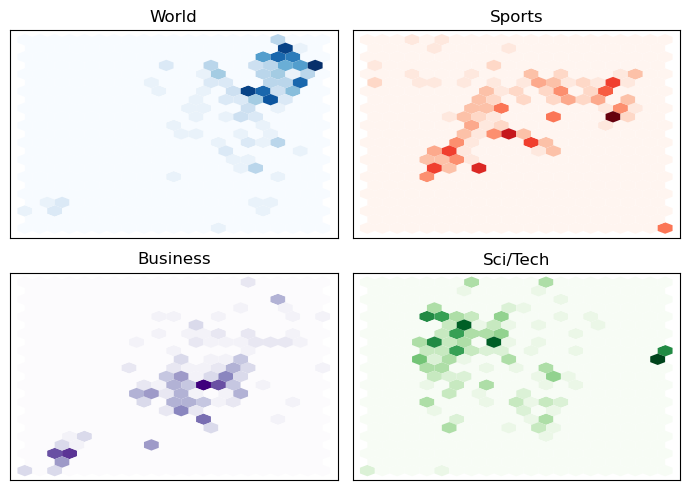

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Blues", "Reds", "Purples", "Greens"]
labels = small_set.features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb[df_emb["label"] == label]
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

<Axes: >

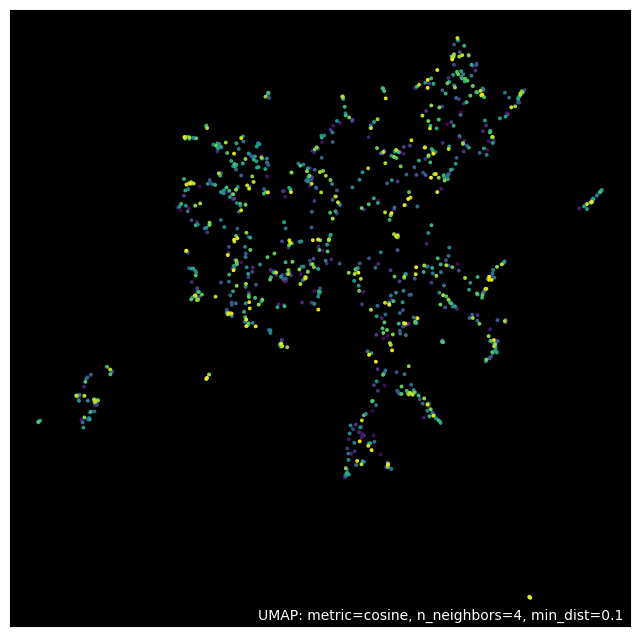

In [80]:
umap.plot.points(mapper, values=np.arange(1000), theme='viridis')

## 5. Conclusion

In conclusion, we have explored a bit of the fascinating world of vector databases, natural language processing, transformers, and embeddings. In this tutorial we learned that (1) vector databases provide efficient storage and retrieval of high-dimensional vectors, making them ideal for similarity-based search tasks. (2) Natural language processing enables us to understand and process human language, opening up possibilities for different kinds of useful applications for digital technologies. (3) Transformers, with their attention mechanism, capture long-range dependencies in language and achieve incredible results in different tasks. Finally, embeddings encode words or sentences into dense vectors, capturing semantic relationships and enabling powerful language understanding.

By combining these technologies, we can unlock new levels of language understanding, information retrieval, and intelligent systems that continue to push the boundaries of what's possible in the realm of AI.

## 6. Resources

Here is a list with some resources that we found useful, and that helped with the development of this tutorial.

1. Books
    - [Natural Language Processing with Transformers](https://transformersbook.com/) by Lewis Tunstall, Leandro von Werra, and Thomas Wolf
    - [Natural Language Processing in Action, Second Edition](https://www.manning.com/books/natural-language-processing-in-action-second-edition) by Hobson Lane and Maria Dyshel
2. Articles
    - [Fine Tuning Similar Cars Search](https://qdrant.tech/articles/cars-recognition/)
    - [Q&A with Similarity Learning](https://qdrant.tech/articles/faq-question-answering/)
    - [Question Answering with LangChain and Qdrant without boilerplate](https://qdrant.tech/articles/langchain-integration/)
    - [Extending ChatGPT with a Qdrant-based knowledge base](https://qdrant.tech/articles/chatgpt-plugin/)
3. Videos
    - [Word Embedding and Word2Vec, Clearly Explained!!!](https://www.youtube.com/watch?v=viZrOnJclY0&ab_channel=StatQuestwithJoshStarmer) by StatQuest with Josh Starmer
    - [Word Embeddings, Bias in ML, Why You Don't Like Math, & Why AI Needs You](https://www.youtube.com/watch?v=25nC0n9ERq4&ab_channel=RachelThomas) by Rachel Thomas
4. Courses
    - [fast.ai Code-First Intro to Natural Language Processing](https://www.youtube.com/playlist?list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9)
    - [NLP Course by Hugging Face](https://huggingface.co/learn/nlp-course/chapter1/1)